In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import pickle
import os

from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

In [2]:
PCT_DATA = .01
N_VOCAB = 100

In [3]:
def rm_stop(words):
    new_words = []
    stop_words = nltk.corpus.stopwords.words('english')

    for w in words:
        if w not in stop_words:
            new_words.append(w)
    return new_words

def build_data(pct_data=PCT_DATA):
    raw_df = pd.read_csv('data/finaldataset.csv')
    raw_df = raw_df.iloc[:round(raw_df.shape[0] * pct_data)]

    df = raw_df[['num_comments', 'title']]
    del raw_df

    df.loc[:,'title'] = df['title'].str.lower()
    tokenizer = nltk.RegexpTokenizer(r'\b[(a-z)]+\b')

    df.loc[:,'tokenized'] = df['title'].apply(tokenizer.tokenize)

    df['tokenized'] = df['tokenized'].apply(rm_stop)
    df['text'] = df['tokenized'].apply(lambda x: ' '.join([word for word in x]))

    return df

def fit_n_vocab(df, n_vocab=N_VOCAB):
    vectorizer = CountVectorizer(max_features=n_vocab)
    vecfit = vectorizer.fit_transform(df['text'])
    X = vecfit.toarray()

    vocab = vectorizer.get_feature_names()
    Y = df['num_comments'].to_numpy()

    return X, Y, vocab, vectorizer 

def pct_no_words(X):
    return sum(np.sum(X, axis=1) > 0)/X.shape[0]

def pred_from_str(q, m, vec):
    tokenizer = nltk.RegexpTokenizer(r'\b[(a-z)]+\b')

    q = tokenizer.tokenize(q)
    q = rm_stop(q)

    j = lambda x: ' '.join([word for word in x])
    q = j(q)
    pred_X = vec.transform(pd.Series(q)).toarray()

    pred = m.predict(pred_X)

    return pred

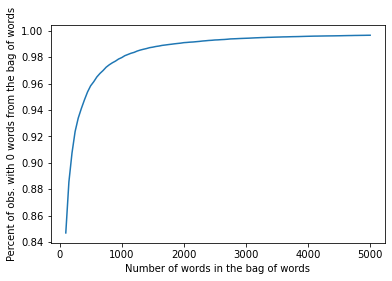

In [4]:
# set run = True if first time running, False otherwise as it takes a while to run
run = False

if run:
    pct_vals = []
    df = build_data()

    for i in tqdm(np.arange(100, 5001, 50)):
        X = fit_n_vocab(df=df, n_vocab=i)[0]
        pct = pct_no_words(X)
        pct_vals.append([i, pct])
    pct_df = pd.DataFrame(pct_vals, columns=['n_vocab', 'pct_words'])
    pct_df.to_csv('pct_df.csv')
else:
    pct_df = pd.read_csv('pct_df.csv')

plt.plot(pct_df['n_vocab'], pct_df['pct_words'])
plt.xlabel('Number of words in the bag of words')
plt.ylabel('Percent of obs. with 0 words from the bag of words')

plt.show()

In [50]:
df = build_data()
X, Y, vocab, vectorizer = fit_n_vocab(df=df, n_vocab=N_VOCAB)


# Y transformation
Y = np.log(Y, dtype=float)

del df

(array([3.279e+03, 4.125e+03, 2.126e+03, 3.370e+02, 6.200e+01, 2.100e+01,
        9.000e+00, 8.000e+00, 4.000e+00, 7.000e+00]),
 array([1.09861229, 1.98653168, 2.87445107, 3.76237047, 4.65028986,
        5.53820925, 6.42612865, 7.31404804, 8.20196743, 9.08988682,
        9.97780622]),
 <BarContainer object of 10 artists>)

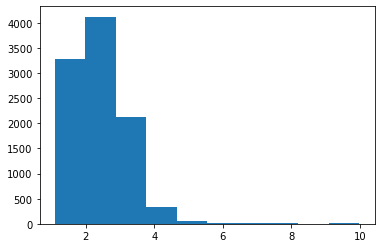

In [49]:
plt.hist(Y)

In [6]:
import statsmodels.api as sm

ols = sm.OLS(Y, X)
ols_fit = ols.fit()

# https://stackoverflow.com/questions/51734180/converting-statsmodels-summary-object-to-pandas-dataframe
vocab_coeff_df = pd.DataFrame({'word': vocab, 'coeff': ols_fit.params, 'pval': ols_fit.pvalues})

In [7]:
vocab_coeff_df.sort_values('coeff', ascending=False)

,word,coeff,pval
54,opinion,1.835214,4.451592e-22
19,favourite,1.719135,5.712537e-21
81,thoughts,1.693542,5.618813e-21
5,biggest,1.687383,4.545969e-24
18,favorite,1.574314,5.476186e-59
...,...,...,...
75,take,0.247871,1.940359e-01
51,new,0.216357,2.445209e-01
24,friend,0.193925,1.816036e-01
10,could,0.179389,7.600573e-02


In [13]:
from xgboost import XGBRegressor

xgbr = XGBRegressor()
xgbr.fit(X, Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [14]:
xgbr.predict(X)

array([2.5224602, 2.409966 , 2.3532548, ..., 2.5376554, 2.0632293,
       2.4864795], dtype=float32)

In [15]:
from sklearn.metrics import mean_squared_error

print(f'MSE of boosted trees: {mean_squared_error(Y, xgbr.predict(X))}')
print(f'MSE of OLS: {mean_squared_error(Y, ols_fit.predict(X))}')

MSE of boosted trees: 0.6835865692916593
MSE of OLS: 2.36670651736035


In [16]:
qs = 'what if thankfully whos username?'
print(np.exp(pred_from_str(qs, xgbr, vectorizer)))
print(np.exp(pred_from_str(qs, ols_fit, vectorizer)))

[24.819849]
[6.88111027]


In [8]:
df = pd.DataFrame(data = X)
df['Y'] = Y

training_data = df.sample(frac = 0.8, random_state = 25)  # random_state serves as a seed
testing_data = df.drop(training_data.index)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

del df

No. of training examples: 7982
No. of testing examples: 1996


In [9]:
X_train = training_data.drop('Y', axis = 1)
X_test = testing_data.drop('Y', axis = 1)

Y_train = training_data['Y']
Y_test = testing_data['Y']

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

randForest = RandomForestRegressor().fit(X_train, Y_train)
scores = cross_val_score(randForest, X_train, Y_train, cv = 5)
scores

array([-0.13508352, -0.12277632, -0.06752203, -0.10442074, -0.11076994])

In [53]:
from sklearn.linear_model import LinearRegression

linReg = LinearRegression().fit(X_train, Y_train)
lin_ypred = linReg.predict(X_train)
print(mean_squared_error(Y_train, lin_ypred))

scorelin = cross_val_score(LinearRegression(), X_train, Y_train, cv = 5, 
                           scoring = 'neg_mean_squared_error')
print(-1*scorelin.mean())

0.676335929737053
0.694184824996021


In [16]:
from sklearn.linear_model import Lasso

lassoReg = Lasso().fit(X_train, Y_train)
lassoReg.score(X_train, Y_train)

0.0

In [56]:
from sklearn.linear_model import Ridge

ridgeReg = Ridge().fit(X_train, Y_train)
ridge_ypred = ridgeReg.predict(X_train)
print(mean_squared_error(Y_train, ridge_ypred))

scoreridge = cross_val_score(Ridge(), X_train, Y_train, cv = 5, 
                           scoring = 'neg_mean_squared_error')
print(-1*scoreridge.mean())

0.6763387097664976
0.6939658846812932


In [60]:
import statsmodels.api as sm

ols = sm.OLS(Y_train, X_train)
ols_fit = ols.fit()

ols_ypred = ols_fit.predict(X_train)
print(mean_squared_error(Y_train, ols_ypred))

2.828248869367714


In [59]:
del ols
del ols_fit

In [43]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

mlpReg = MLPRegressor(max_iter = 500, random_state = 1).fit(X_train, Y_train)
#print(mlpReg.score(X_train, Y_train))

ypred = mlpReg.predict(X_train)
print(mean_squared_error(Y_train, ypred))

scoreMLP = cross_val_score(MLPRegressor(max_iter = 500, random_state = 1), X_train, Y_train, cv = 5, 
                           scoring = 'neg_mean_squared_error')
print(-1*scoreMLP.mean())



0.4232551898203105
0.9373989289273446


In [52]:
from sklearn.neighbors import KNeighborsRegressor

kReg = KNeighborsRegressor().fit(X_train, Y_train)
k_ypred = kReg.predict(X_train)
print(mean_squared_error(Y_train, k_ypred))

scoreK = cross_val_score(KNeighborsRegressor(), X_train, Y_train, cv = 5, 
                           scoring = 'neg_mean_squared_error')
print(-1*scoreK.mean())



0.7199426985446578
0.8282334772548527


In [19]:
X_train.shape, Y_train.shape

((159644, 500), (159644,))

In [20]:
X_test.shape, Y_test.shape

((39911, 500), (39911,))